In [3]:
from IPython.display import Image
from evolution import Evolution
%matplotlib inline

## Introduction

Notre objectif est de créer une intelligence artificielle capable de réaliser des bons scores au jeu UnderTheLine. Ce jeu a été imaginé et implémenté dans le cadre du projet Python de première année de l'ENSAE. Pour ce faire nous allons faire appel à un algorithme évolutionniste. L'idée est de générer aléatoirement un ensemble d'individus que l'on teste en les faisant jouer au jeu. Les plus mauvais sont écartés et les meilleurs sont gardés et mutés afin de créer la deuxième génération. En itérant ce processus, on crée une lignée qui joue de mieux en mieux au jeu. La vitesse de progression de la lignée dépend en grande partie de la structure des individus. Nous avons choisi comme intelligence des individus un réseau de neurones simple. Il n'est pas très difficile de trouver des algorithmes de neuroevolution pertinents, néanmoins, obtenir une intelligence artificielle efficace peut être très long car cela requière une grande quantité de calcul. D'après la littérature, les premiers individus intéressant apparaissent dans ce genre d'algorithme au bout de plusieurs centaines de milliers de générations. L'enjeu est assurément d'optimiser le temps de calcul. Nous allons profiter de l'indépendance de chaque individu au sein d'une génération pour paralléliser leur évaluation sur gpu.

## Le jeu

UnderTheLine se joue sur une grille contenant des cases numérotées.

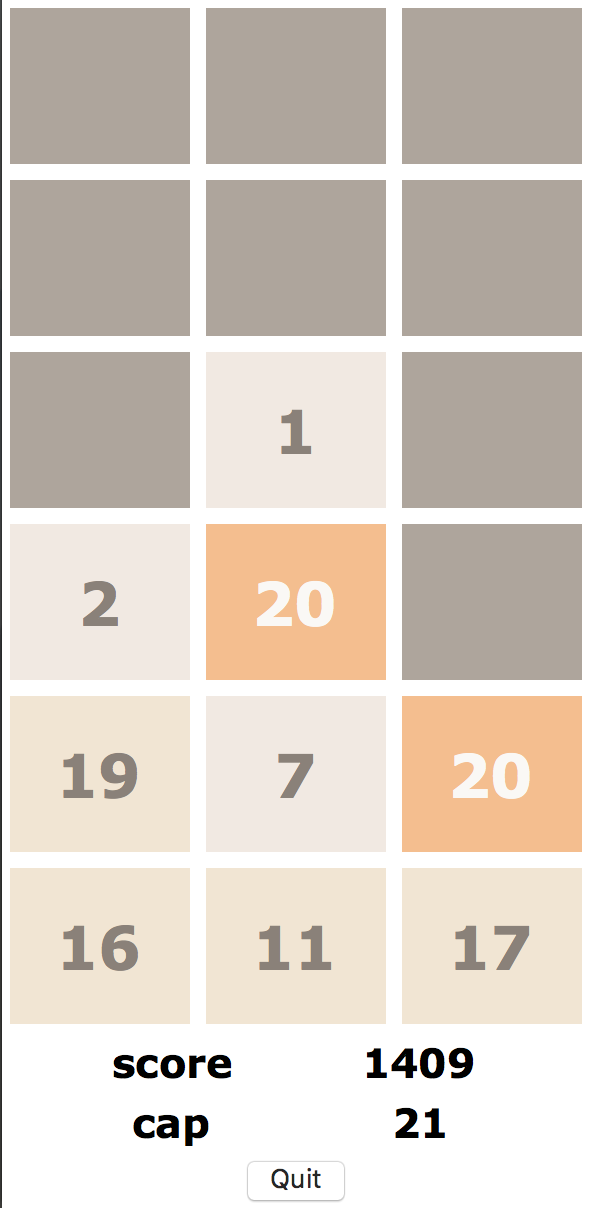

In [2]:
Image("img/game.png", width=200, height=200)

Les cases sont soumises à la gravité, elles tombent systématiquement.

La seule action possible du jeu est la fusion de deux cases avec un "drag&drop".

Lorsque deux cases fusionnent, leurs numéros s'additionnent sauf si elles ont le même numéro, dans ce cas, la case fille porte le numéro des deux cases mères.

Le cap du jeu est une valeur seuil qui croît avec le score : il n'est pas possible de faire apparaitre une case avec un numéro dépassant ce cap.

Une nouvelle case apparait lorsque deux cases qui n'ont pas le même numéro fusionnent.

Il y a "Game Over" quand une case atteint la ligne du haut.

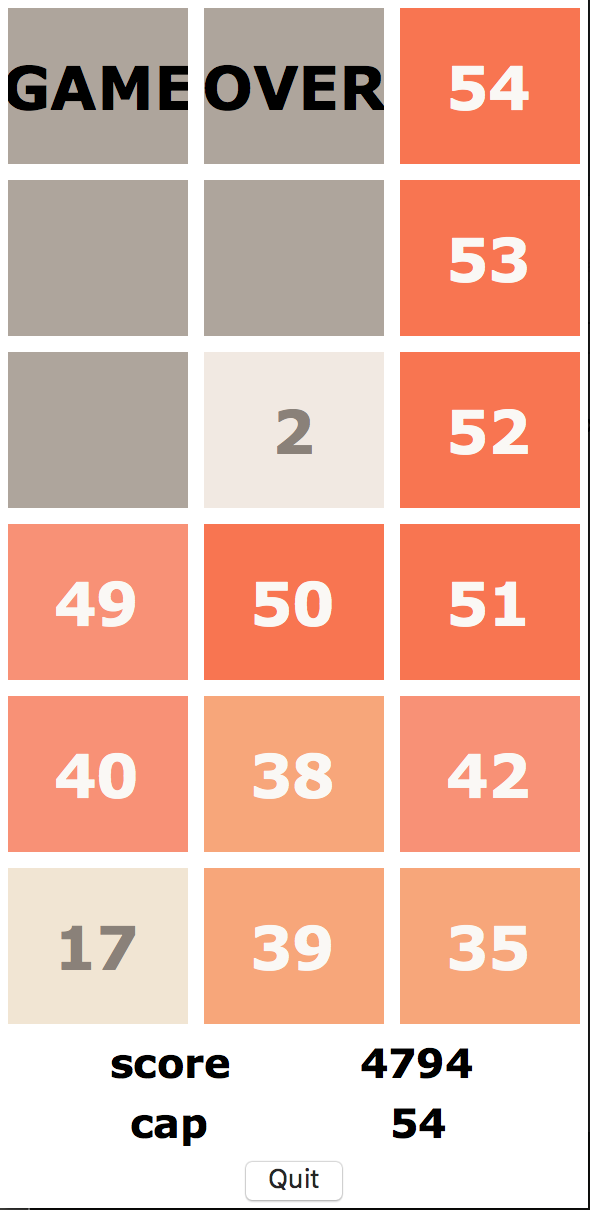

In [3]:
Image("img/gameover.png", width=200, height=200)

## L'intelligence artificielle

Nous avons choisi un réseau de neurone comme structure d'apprentissage de chaque individu. Ce réseau prend en argument la grille des numéros (les cases vides sont numérotées par 0 et la matrice est normalisée L1) et sort en output un score pour chaque coup. Le coup joué est alors celui avec le meilleur score parmi les coups possibles (respectant les contraintes du jeu). Le réseau comporte deux couches cachées et la fonction sigmoïde comme fonction d'activation. La taille de l'output du réseau de neurones correspond au nombre des différents coups possibles.

#### Calcul du nombre de coups possibles

Les cases les plus hautes ne sont pas déplacables car si il en existe une, la partie est finie.

Les cases tombent systémtiquement, ainsi, les déplacements vers le haut sont équivalentes aux déplacements vers le bas. Si on note n le nombre de lignes et p le nombre de colonnes de la grille de jeu, il existe donc (n-1)p différents coups verticaux possibles.

On ne peut pas non plus déplacer les cases toutes à gauche vers la gauche, il existe donc (n-1)x(p-1) coups vers la gauche et, par symétrie, 2(n-1)x(p-1) différents coups horizontaux possibles.

Il y a donc enfin (n-1)x(3p-2) différents coups possibles.

#### Creation et mutation

La création d'un individu correspond à la génération aléatoire d'un réseau de neurones avec des poids entre -1 et 1.

La mutation d'un individu correspond à une variation aléatoire de ses poids entre -0.2 et 0.2.

## Implémentation

On commence par implémenter une version "classique" en utilisant majoritairement le package numpy.

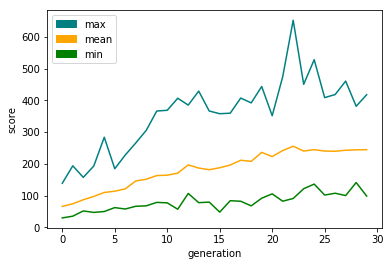

In [4]:
evolution = Evolution(
    generation_nb=30, # nombre de générations
    generation_size=50, # nombre d'individus
    game_per_generation=10, # nombre de parties jouées pour chaque individu
    row_nb=6,
    column_nb=3,
    cap=7,
    use_gpu=False
)

evolution.train()

On implémente ensuite la version distribuée.

In [ ]:
evolution_gpu = Evolution(
    generation_nb=30, # nombre de générations
    generation_size=50, # nombre d'individus
    game_per_generation=10, # nombre de parties jouées pour chaque individu
    row_nb=6,
    column_nb=3,
    cap=7,
    use_gpu=True
)

evolution_gpu.train()

Ces graphes montrent l'évolution des scores au fil des générations. Les scores ont tendance à progresser même si ils peuvent stagner longtemps avant de repartir brusquement grâce à une mutation avantageuse. Le comportement est le même dans les deux cas mais l'algorithme distribué est plus lent pour notre configuration.

### Parallélisation avec pyCuda



##### les coups

Pour chaque individu on effectue 3 multiplications matricielles afin de determiner l'output du réseau de neurone et ainsi le coup à jouer. Afin de calculer ces mutliplications pour chaque individu en parallèle, on construit un block pour chaque individu et un thread pour chaque coefficient du résultat du produit matriciel.

##### La modification de la grille de jeu

On parallélise deux étapes d'un tour : le déplacement par « drag&drop » et la gravité. Dans les deux cas, on crée les emplacements mémoire nécessaires sur le GPU. 
Pour le « drag&drop » on utilise un unique bloc dans lequel chaque thread correspond à un individu. (« remodeling.py »)
Pour la gravité on défini un bloc par individu et un thread par colonne. (« gravity.py »).


### Strucutre du code 

Chaque génération d’intelligence artificielle est implémentée grâce à la classe « génération ». Cette classe contient notamment les différents réseaux de neurones composant une génération (attribut « self.intelligence ») et les différentes méthodes qui assurent l’exécution simultanée des parties de toute la génération.

L’apprentissage s’effectue grâce à la classe « évolution ». Celle-ci possède en attribut un élément de la classe « génération », la méthode « nextgen » qui permet de passer d’une génération à la suivante et la méthode « train » qui conduit l’entraînement en appliquant successivement « nextgen ».

L’intelligence artificielle d’une génération est définie par la classe « neuralNetworkGPU » du fichier « neuralNetworkGPU.py » :  elle possède en attribut les matrices des réseaux de neurones et contient les méthodes permettant le calcul des outputs des réseaux. Parmi celles-ci on trouve la méthode « gpu_mult » qui conduit la multiplication matricielle distribuée sur le GPU. 

Le fichier « gravity.py » contient la définition de la fonction « gravity_gpu » qui permet d’appliquer la gravité simultanément à tous les individus d’une génération et « remodeling.py » contient la définition de « remodeling_gpu » qui permet d’effectuer en parallèle le « drag&drop » pour chaque intdividu d’une génération. 

Les autres scripts servent à implémenter l’algorithme évolutionniste sur cpu de façon « classique » (« kernyl.py », « individual.py »).

### Problèmes rencontrés


Le fait que l'on ne peut paralléliser qu'une partie de l'algorithme entraîne des pertes de temps importantes. 
Pour tenter de réduire le temps d’exécution nous avons pensé à implémenter la multiplication matricielle de façon à n’allouer qu’une seule fois la mémoire GPU nécessaire. (Cf attributs « self.syn0_gpu »,« self.syn1_gpu », « self.syn2_gpu » etc… qui sont passés en arguments de « gpu_mult » ). Bien que cette solution nous ait permis d’accélérer les calculs (on passe de 20ms à 14ms pour la détermination d’un coup d’une génération entière), le temps d’exécution reste élevé notamment à cause des transferts successifs de la mémoire CPU vers la mémoire GPU et vice-versa. En effet la structure de notre code impose de faire beaucoup « d’aller et retour » entre Python et Cuda car beaucoup d’opérations ne sont pas implémentables sur GPU. 

Les coûts fixes liés à l’utilisation de pyCuda sont tels que pour des opérations élémentaires (multiplication par 2) il faut 500 000 matrices 6x3 pour que la parallelisation soit rentable or l ‘efficacité de l’algorithme d’évolution ne réside pas dans le nombre d’individus mais dans celui de génération ce qui peut expliquer les performances que nous avons obtenues. 

Un autre exemple de difficultés que nous avons rencontré est la gestion de l’aléatoire dans pyCuda : pour générer aléatoirement des nombres sur gpu (via « currand() ») il faut allouer de la mémoire supplémentaire ce qui dans notre cas aurait augmenté les coûts fixes. 